# Wisconsin Breast Cancer (Diagnostic) DataSet Analysis

*Zexin Li* (zexinli2020@outlook.com)

13.07.2021

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from alibi.explainers import KernelShap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Loading Dataset

In [2]:
colname = ['code','thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses','class']
dataset = pd.read_csv("breast-cancer-wisconsin.data", names=colname)
print("Rows:",len(dataset))
print("Columns:",len(dataset.columns))
dataset.head()

Rows: 699
Columns: 11


,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## 2. Data exploration

### 2.1. Describe the whole dataset

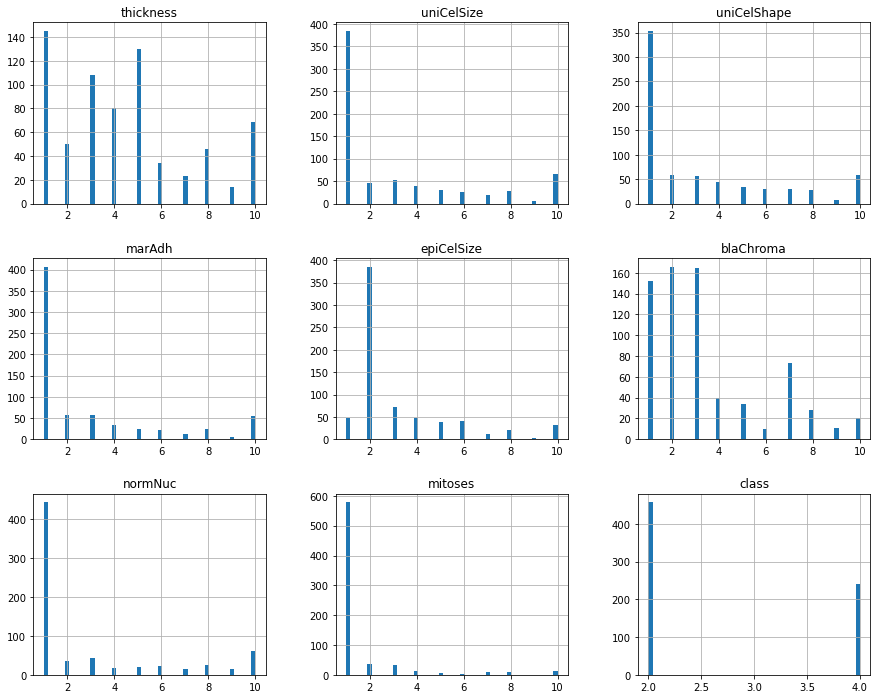

In [134]:
dataset.iloc[:,1:].hist(bins=50, figsize = (15,12),)  # the first column is identity sample number
plt.show()

Every features are numerical variables.

There is no unexpected zero value as missing value.

But note that **Bare Nuclei** does not be plotted here may be due to some non-numerical value.

### 2.2. Describe the dataset by stratified groups

     Group 1: 367 instances (January 1989)
     Group 2:  70 instances (October 1989)
     Group 3:  31 instances (February 1990)
     Group 4:  17 instances (April 1990)
     Group 5:  48 instances (August 1990)
     Group 6:  49 instances (Updated January 1991)
     Group 7:  31 instances (June 1991)
     Group 8:  86 instances (November 1991)
     -----------------------------------------
     Total:   699 points (as of the donated datbase on 15 July 1992)

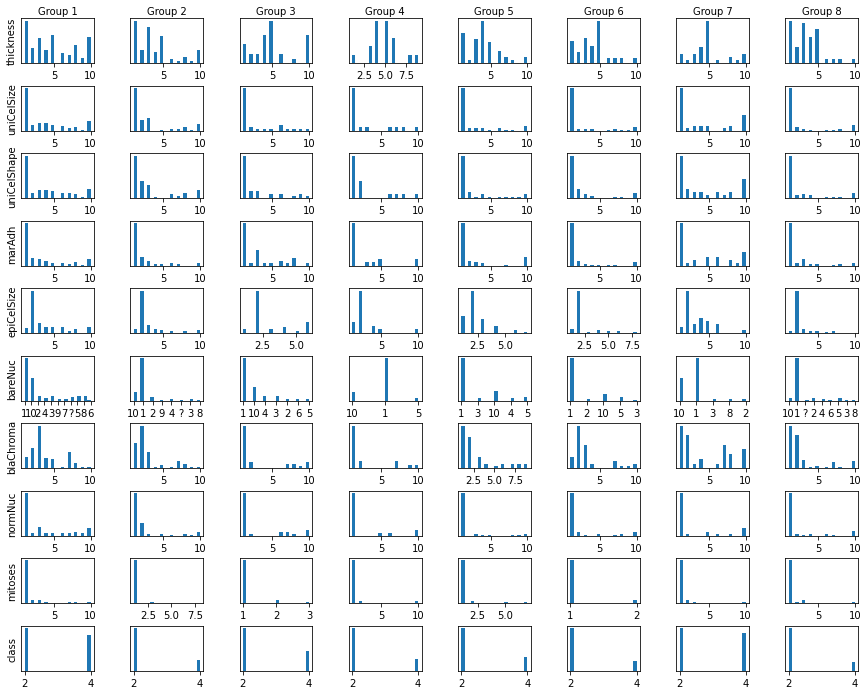

In [135]:
groups = [0, 366, 436, 467, 484, 532, 581, 612,699]   # separated points of row index for each group

fig, ax = plt.subplots(10,8,figsize=(15,12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
    col = dataset.columns[i+1]
    for j in range(8):
        ax[i,j].hist(dataset.loc[groups[j]:groups[j+1],col], bins=20)
#         ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j == 0:
            ax[i,j].set_ylabel(col)
        if i ==0:
            ax[i,j].xaxis.set_label_position('top') 
            ax[i,j].set_xlabel(f"Group {j+1}")
plt.show()

Look at the Group 1,2 and 8, the missing values of bareNuc are marked as a non-numerical value '?'. When we impute them in the following analysis, it is unavoidable to result in some bias of these group.

### 2.3. Check missing value

In [136]:
dataset.isna().sum()

code           0
thickness      0
uniCelSize     0
uniCelShape    0
marAdh         0
epiCelSize     0
bareNuc        0
blaChroma      0
normNuc        0
mitoses        0
class          0
dtype: int64

However, according to the basic information of this dataset, 16 missing attribute values are marked as '?'.

In [137]:
missing_rows = dataset[dataset['bareNuc']=='?']
print("Missing rows:",len(missing_rows))

Missing rows: 16


In [138]:
missing_rows

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


In order to make the following exploration, here we simply remove the row of missing values.

In [139]:
dataset.drop(missing_rows.index, inplace=True)
dataset[['bareNuc']] = dataset[['bareNuc']].astype(np.int64)
dataset[dataset['bareNuc']=='?']

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class


### 2.4. Check duplicated values

In [140]:
dataset.duplicated().sum()

8

In [141]:
dataset[dataset['code']==1033078]

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In this case, it is possible for a sample in which contains multiple instances.

### 2.5. Check multi-collinearity

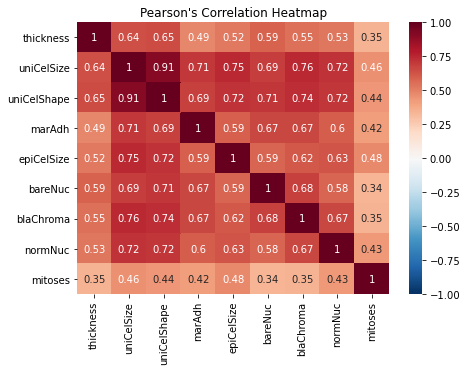

In [142]:
X = dataset.drop(['code','class'], axis=1)
y = dataset['class']
plt.figure(figsize=(7,5))
corr = X.corr(method = "pearson")
p = sns.heatmap(corr,vmin=-1, vmax=1,annot=True, cmap='RdBu_r')
p.set_title('Pearson\'s Correlation Heatmap')
plt.show()

**Uniformity of Cell Size** and **Uniformity of Cell Shape** are highly correlated (person coefficient> 0.9). The row data is unsafe to build SVM and LR model.

## 3. Data pre-processing

### 3.1. Imputation

Since the data is limited, we must consider a suitable way to fill the missing values, instead of removing them directly.

In [2]:
# Reloading dataset
colname = ['code','thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses','class']
dataset = pd.read_csv("breast-cancer-wisconsin.data", names=colname)

# Imputating 'bareNuc' column with median
dataset['bareNuc'] = dataset['bareNuc'].replace('?',0).astype(np.int64)
im = SimpleImputer(missing_values = 0, strategy = 'median')
im_bareNuc = im.fit_transform(dataset[['bareNuc']])
dataset[['bareNuc']] = im_bareNuc

In [3]:
dataset[dataset['bareNuc']=='?']

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class


### 3.2. Split training and test dataset

In [4]:
# Create features and labels 
X = dataset.drop(['code','class'], axis=1)
y = dataset['class']

# Create training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [5]:
y_train.value_counts()

2    340
4    184
Name: class, dtype: int64

In [6]:
y_test.value_counts()

2    118
4     57
Name: class, dtype: int64

### 3.3. Rebalance

Due to the imbalance of data of different classes, we have to up/downsample the dataset.

In [7]:
# Data up-sampling
df = pd.concat([X_train, y_train],axis=1)

df_majority = df[df['class']==2] 
df_minority = df[df['class']==4]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=340,
                                 random_state=1)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# re-preparing the training sets
X_train = df_upsampled.drop(['class'], axis=1)
y_train = df_upsampled[['class']]

y_train.value_counts()

class
2        340
4        340
dtype: int64

### 3.4. Scaling

Some models we will compare such as kNN, SVM, Regression do not perform well when the input values have different scales. Before implementing them, we have to conduct data scaling.

In [8]:
# Implement scaling using standardiation
standardScaler = StandardScaler()
X_train_scaled = standardScaler.fit_transform(X_train)
X_test_scaled = standardScaler.transform(X_test)

### 3.5. Decorrelation

Since this dataset has multi-collinearity to which SVM and LR models are sensitive, we need to de-correlate the dataset before building model. Here the dataset is de-correlated with PCA.

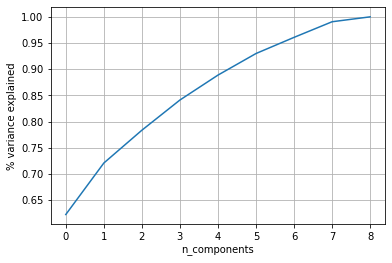

In [9]:
pca = PCA(n_components = X_train_scaled.shape[1], random_state=1)
pca_data = pca.fit_transform(X_train_scaled)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [10]:
cumm_var_explained

array([0.62244255, 0.72077635, 0.78346917, 0.84113101, 0.88872115,
       0.92996032, 0.96080513, 0.99063011, 1.        ])

**Correlation matrix after PCA decorrelation**

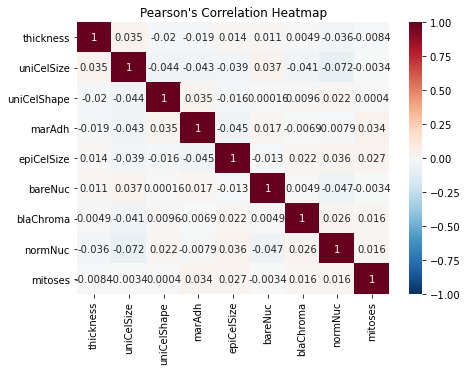

In [11]:
pca = PCA(n_components = X_train_scaled.shape[1], random_state=1)
pca_train_data = pca.fit_transform(X_train_scaled)
pca_test_data = pca.transform(X_test_scaled)

X_train = pd.DataFrame(pca_train_data)
X_test = pd.DataFrame(pca_test_data)
X_train.columns = ['thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses']
X_test.columns = ['thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses']
df_train_pca = pd.concat([X_train, X_test], axis=0)

corr = df_train_pca.corr()
plt.figure(figsize=(7,5))
corr = df_train_pca.corr(method = "pearson")
p = sns.heatmap(corr,vmin=-1, vmax=1,annot=True, cmap='RdBu_r')
p.set_title('Pearson\'s Correlation Heatmap')
plt.show()

In [12]:
df_train_pca.head()

,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses
0,-2.309022,0.028929,-0.623741,-0.503424,0.341166,-0.233568,0.107822,0.527056,0.048492
1,-2.684481,0.250676,-0.031812,-0.515013,0.190438,-0.100614,-0.075990,0.305790,0.032825
2,-1.706891,-0.026022,0.117155,0.340032,-0.527386,-0.210158,0.095547,-0.422971,0.048748
3,-2.261970,0.104539,-0.306997,-0.803155,-0.037661,0.004270,0.173303,0.572970,0.209722
4,-2.421156,-0.020864,-0.044885,-0.655830,0.253832,0.048175,-0.176144,-0.308477,-0.007709


## 4. Comparision of different ML models

### 4.1 Fine tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

models = {
    'KNN': KNeighborsClassifier(),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'DT': DecisionTreeClassifier(),
    'RM': RandomForestClassifier(),
}

params={'KNN': {'selectkbest__k':[1,2,3,4,5,6],
                'kneighborsclassifier__n_neighbors' : [3,5,7,9,11,13,15],
                'kneighborsclassifier__weights' : ['uniform', 'distance'],
                'kneighborsclassifier__metric' : ['euclidian','manhattan']
                                 },
        'LR': {'selectkbest__k':[1,2,3,4,5,6],
               'logisticregression__C' : [0.01, 0.1, 1, 10, 100],
               'logisticregression__penalty' : ['l1','l2','elastic-net','None'],
               'logisticregression__solver' : ['liblinear','newton-cg','lbfgs','sag','saga']
                              },
        'SVM': {'selectkbest__k':[1,2,3,4,5,6],
                'svc__kernel' : ['rbf','linear','sigmoid'],
                'svc__gamma' : [0.1, 1, 10, 100],
                'svc__degree' : [0, 1, 2, 3, 4, 5],
                'svc__C' : [0.01, 0.1, 1, 10, 100]
               },
        'DT':{'selectkbest__k':[1,2,3,4,5,6],
              'decisiontreeclassifier__splitter' : ['best', 'random'],
              'decisiontreeclassifier__criterion' : ['gini', 'entropy']
             },
        'RM':{'selectkbest__k':[1,2,3,4,5,6],
              'randomforestclassifier__n_estimators' : [30,40,50,60,70],
              'randomforestclassifier__criterion' : ['gini', 'entropy'],
              'randomforestclassifier__max_features' : ["auto", "sqrt", "log2"], 
              'randomforestclassifier__oob_score' : ['True','False']
             },
       }

trained_models = {}
for name in models.keys():
    est = models[name]
    est_params = params[name]
    pipe = make_pipeline(StandardScaler(),SelectKBest(f_regression) ,est)
    gs = GridSearchCV(pipe, param_grid=est_params, verbose=False, n_jobs=-1, cv=10)
    gs.fit(X_train, y_train)
    trained_models[name] = gs
    print(f"------{name}------")
    print(f"Best score: {gs.best_score_}")
    print(f"Best parameters are: {gs.best_params_}")

------KNN------
Best score: 0.9808823529411766
Best parameters are: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance', 'selectkbest__k': 6}
------LR------
Best score: 0.9661764705882353
Best parameters are: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'selectkbest__k': 1}
------SVM------
Best score: 0.9764705882352942
Best parameters are: {'selectkbest__k': 1, 'svc__C': 10, 'svc__degree': 0, 'svc__gamma': 100, 'svc__kernel': 'rbf'}
------DT------
Best score: 0.9808823529411764
Best parameters are: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__splitter': 'random', 'selectkbest__k': 5}
------RM------
Best score: 0.9794117647058824
Best parameters are: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__oob_score'

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

models = {
    'KNN': KNeighborsClassifier(),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'DT': DecisionTreeClassifier(),
    'RM': RandomForestClassifier(),
}

params={'KNN': {'selectkbest__k':[1,2,3,4,5,6],
                'kneighborsclassifier__n_neighbors' : [3,5,7,9,11,13,15],
                'kneighborsclassifier__weights' : ['uniform', 'distance'],
                'kneighborsclassifier__metric' : ['euclidian','manhattan']
                                 },
        'LR': {'selectkbest__k':[1,2,3,4,5,6],
               'logisticregression__C' : [0.01, 0.1, 1, 10, 100],
               'logisticregression__penalty' : ['l1','l2','elastic-net','None'],
               'logisticregression__solver' : ['liblinear','newton-cg','lbfgs','sag','saga']
                              },
        'SVM': {'selectkbest__k':[1,2,3,4,5,6],
                'svc__kernel' : ['rbf','linear','sigmoid'],
                'svc__gamma' : [0.1, 1, 10, 100],
                'svc__degree' : [0, 1, 2, 3, 4, 5],
                'svc__C' : [0.01, 0.1, 1, 10, 100]
               },
        'DT':{'selectkbest__k':[1,2,3,4,5,6],
              'decisiontreeclassifier__splitter' : ['best', 'random'],
              'decisiontreeclassifier__criterion' : ['gini', 'entropy']
             },
        'RM':{'selectkbest__k':[1,2,3,4,5,6],
              'randomforestclassifier__n_estimators' : [30,40,50,60,70],
              'randomforestclassifier__criterion' : ['gini', 'entropy'],
              'randomforestclassifier__max_features' : ["auto", "sqrt", "log2"], 
              'randomforestclassifier__oob_score' : ['True','False']
             },
       }

trained_models = {}
for name in models.keys():
    est = models[name]
    est_params = params[name]
    pipe = make_pipeline(StandardScaler(),SelectKBest(f_regression) ,est)
    gs = GridSearchCV(pipe, param_grid=est_params, verbose=False, n_jobs=-1, cv=10)
    gs.fit(X_train, y_train)
    trained_models[name] = gs
    print(f"------{name}------")
    print(f"Best score: {gs.best_score_}")
    print(f"Best parameters are: {gs.best_params_}")

------KNN------
Best score: 0.9808823529411766
Best parameters are: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance', 'selectkbest__k': 6}
------LR------
Best score: 0.9661764705882353
Best parameters are: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'selectkbest__k': 1}
------SVM------
Best score: 0.9764705882352942
Best parameters are: {'selectkbest__k': 1, 'svc__C': 10, 'svc__degree': 0, 'svc__gamma': 100, 'svc__kernel': 'rbf'}
------DT------
Best score: 0.9808823529411764
Best parameters are: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__splitter': 'random', 'selectkbest__k': 1}
------RM------
Best score: 0.9794117647058824
Best parameters are: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__oob_score'

Each ML model demonstrates very good performance on the breast cancer dataset. Comparing the optimal case of all the ML models, they have very close best scores. Thus, we then look at more metrics to evaluate the performance of these models.

### 4.2 Evaluation by other metrics

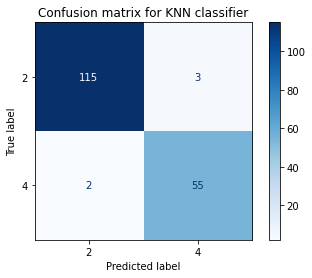

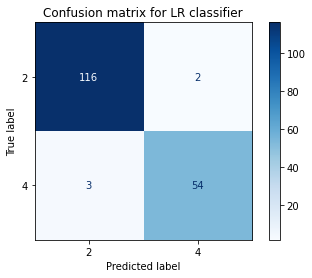

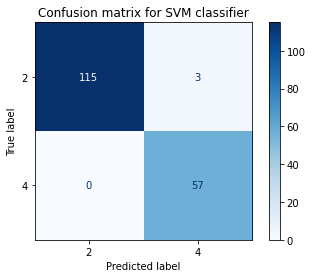

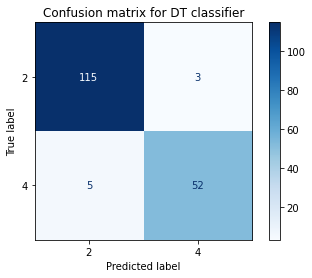

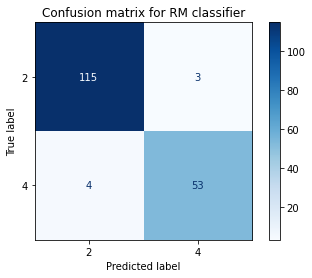

In [76]:
for name in models.keys():
    pred = trained_models[name].predict(X_test)
    cm = confusion_matrix(y_test, pred)

    title = f'Confusion matrix for {name} classifier'
    disp = plot_confusion_matrix(trained_models[name],
                                 X_test,
                                 y_test,
                                 cmap=plt.cm.Blues,
                                )
    disp.ax_.set_title(title)
    plt.show()

In [22]:
def display_metrics(labels_test, pred):
    # accuracy
    accuracy = accuracy_score(labels_test, pred)
    print('Accuracy: {:.2f}'.format(accuracy))
    
    # precision
    precision = precision_score(labels_test, pred, pos_label=4)
    print ('Precision: {:.2f}'.format(precision))

    # recall
    recall = recall_score(labels_test, pred, pos_label=4)
    print ('Recall: {:.2f}'.format(recall))

    # F1 score
    f1 = f1_score(labels_test, pred, pos_label=4)
    print ('F1 score: {:.2f}'.format(f1))

    # AUROC
    auroc = roc_auc_score(labels_test, pred)
    print ('AUROC score: {:.2f}'.format(auroc))
    return accuracy, precision, recall, f1, auroc


def plot_roc_curve(labels_test, pred, model):
    fpr, tpr, thresholds = roc_curve(labels_test, pred, pos_label=4)
    speci = 1 - fpr
    print('Specificity: {:.2f}'.format(speci[1]))
    plt.plot(fpr, tpr, label=model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()

------KNN------
Accuracy: 0.97
Precision: 0.95
Recall: 0.96
F1 score: 0.96
AUROC score: 0.97
Specificity: 0.97
------LR------
Accuracy: 0.97
Precision: 0.96
Recall: 0.95
F1 score: 0.96
AUROC score: 0.97
Specificity: 0.98
------SVM------
Accuracy: 0.98
Precision: 0.95
Recall: 1.00
F1 score: 0.97
AUROC score: 0.99
Specificity: 0.97
------DT------
Accuracy: 0.95
Precision: 0.95
Recall: 0.91
F1 score: 0.93
AUROC score: 0.94
Specificity: 0.97
------RM------
Accuracy: 0.96
Precision: 0.95
Recall: 0.93
F1 score: 0.94
AUROC score: 0.95
Specificity: 0.97


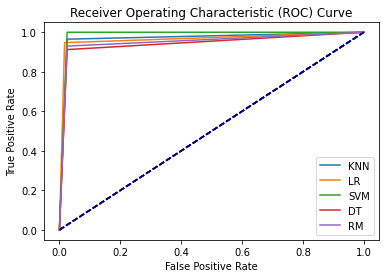

In [23]:
pred = trained_models['KNN'].predict(X_test)
print("------KNN------")
accuracy, precision, recall, f1, auroc = display_metrics(y_test, pred)
plot_roc_curve(y_test, pred, 'KNN')

pred = trained_models['LR'].predict(X_test)
print("------LR------")
accuracy, precision, recall, f1, auroc = display_metrics(y_test, pred)
plot_roc_curve(y_test, pred, 'LR')

pred = trained_models['SVM'].predict(X_test)
print("------SVM------")
accuracy, precision, recall, f1, auroc = display_metrics(y_test, pred)
plot_roc_curve(y_test, pred, 'SVM')

pred = trained_models['DT'].predict(X_test)
print("------DT------")
accuracy, precision, recall, f1, auroc = display_metrics(y_test, pred)
plot_roc_curve(y_test, pred, 'DT')

pred = trained_models['RM'].predict(X_test)
print("------RM------")
accuracy, precision, recall, f1, auroc = display_metrics(y_test, pred)
plot_roc_curve(y_test, pred, 'RM')

SVM shows the highest recall score, F1 score as well as auroc score. The best auroc score of SVM among all the models is coincided with the result of *Sidey-Gibbons, Jenni AM, and Chris J. Sidey-Gibbons, 2019*.

### 4.3 Ranking ML algorithms

Considering every metrics shown above, SVM is the best due to the highest accuracy, AUROC score and perfect recall score(sensitivity).

Rank: Support vector machine >  k-nearest neighbors > Logistic regression > Random forest > Decision tree 

## 5. Feature importance

In [81]:
pred_fcn = trained_models['SVM'].decision_function
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train)
# expected_values attribute stores average scores across training set for every binary SVM
mean_scores_train = pred_fcn(X_train).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)
svm_explanation = svm_explainer.explain(X_test, l1_reg=False)

Large datasets can cause slow runtimes for shap. The background dataset provided has 680 records. Consider passing a subset or allowing the algorithm to automatically summarize the data by setting the summarise_background=True orsetting summarise_background to 'auto' which will default to 300 samples!
Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


1.3877787807814457e-17


  0%|          | 0/175 [00:00<?, ?it/s]

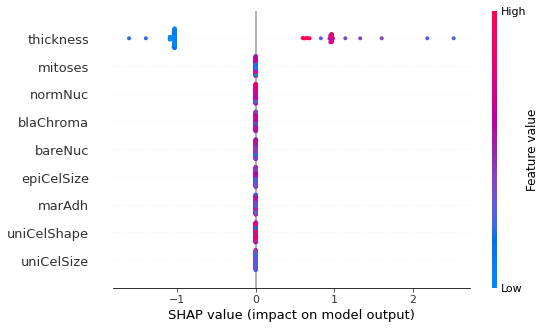

In [86]:
feature_names = ['feature 1','feature 2','feature 3','feature 4','feature 5','feature 6','feature 7','feature 8','feature 9']
shap.summary_plot(svm_explanation.shap_values[0], X_test, feature_names)

Beeswarm plot shows that the most important feature is feature 1, also, the higher feature 1 implies possitive impact on model output (i.e. class = 4, the malignant case), while other features contributes little. Apparently, this result is not coincided with what we expected. 

The first reason is because SVM model is built based on non-linear kernel rbf that maps all the data to higher dimensionality in which the the properties of data have changed compared to original data in low dimensionality. Therefore, we can not determine the feature importance with regard to SVM model in theory.

The second reason is that PCA does not preserve the features of data, rather, they produce linear combination of original features. In this case, SVM sacrifice ordering of feature importance for better performance of model.

## 6. Discussion: feature importance ordering in previous research

I find two relevant researches analysing this dataset, and they use random forest for which Python provide easy way to get feature importance. This is why people prefer to random forest at most of time.

No. 1:

refer to *Ahmad, F. K., & Yusoff, N., 2013*

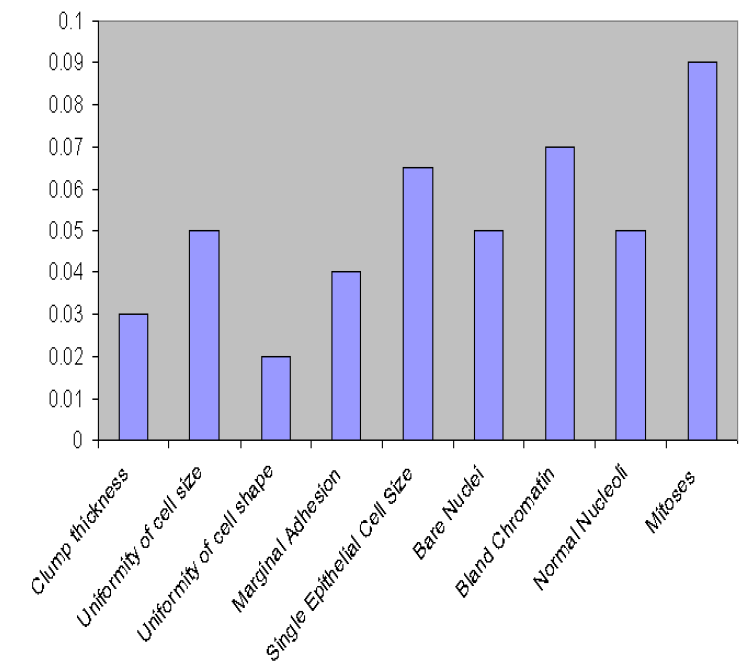

No. 2:

refer to https://shiring.github.io/machine_learning/2017/01/15/rfe_ga_post

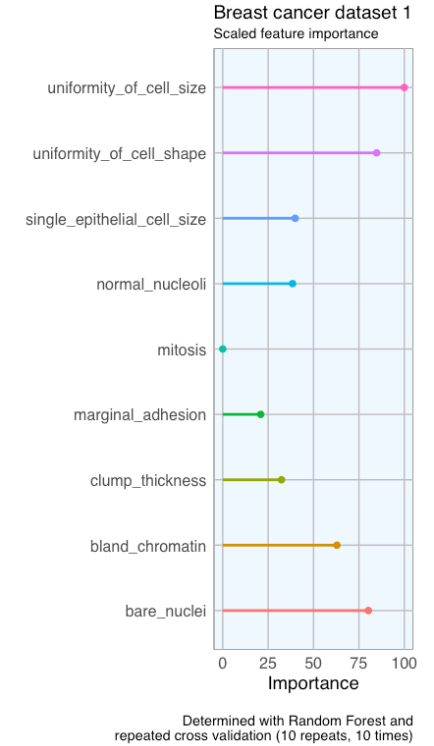

Here I try to order the feature importance based on random forest algorithm.

Feature ranking:
1. thickness (0.537309)
2. uniCelSize (0.180525)
3. bareNuc (0.082582)
4. uniCelShape (0.070072)
5. marAdh (0.054979)
6. blaChroma (0.027269)
7. epiCelSize (0.022478)
8. normNuc (0.015879)
9. mitoses (0.008908)


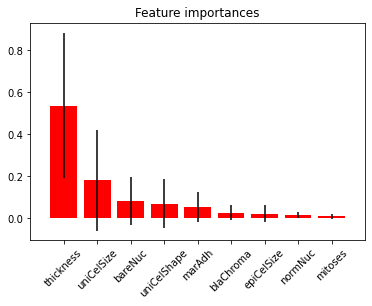

In [295]:
clf = RandomForestClassifier(n_estimators=30)
clf.fit(X_train, y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(min(20,X_train.shape[1])):    
    print("%d. %s (%f)" % (f+1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Even though I use the random forest, my result is still different from that of literature. Thickness is still the most important feature. The problem may be due to the data pre-processing proccess, particularly de-correlation. Next I will reload the dataset and do not process multi-collinearity.

#### a. Imputation

In [28]:
# Reloading dataset
colname = ['code','thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses','class']
dataset = pd.read_csv("breast-cancer-wisconsin.data", names=colname)

# Imputating 'bareNuc' column with median
dataset['bareNuc'] = dataset['bareNuc'].replace('?',0).astype(np.int64)
im = SimpleImputer(missing_values = 0, strategy = 'median')
im_bareNuc = im.fit_transform(dataset[['bareNuc']])
dataset[['bareNuc']] = im_bareNuc

In [312]:
dataset[dataset['bareNuc']=='?']

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class


#### b. Split dataset

In [29]:
# Create features and labels 
X = dataset.drop(['code','class'], axis=1)
y = dataset['class']

# Create training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [30]:
y_train.value_counts()

2    340
4    184
Name: class, dtype: int64

In [31]:
y_test.value_counts()

2    118
4     57
Name: class, dtype: int64

#### c. Rebalance

In [32]:
# Data up-sampling
df = pd.concat([X_train, y_train],axis=1)

df_majority = df[df['class']==2] 
df_minority = df[df['class']==4]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=340,
                                 random_state=1)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# re-preparing the training sets
X_train = df_upsampled.drop(['class'], axis=1)
y_train = df_upsampled[['class']]

y_train.value_counts()

class
2        340
4        340
dtype: int64

#### d. Scaling

In [33]:
# Implement scaling using standardiation
standardScaler = StandardScaler()
X_train_scaled = standardScaler.fit_transform(X_train)
X_test_scaled = standardScaler.transform(X_test)

#### e. Feature importance

Feature ranking:
1. uniCelSize (0.299522)
2. uniCelShape (0.219579)
3. bareNuc (0.169291)
4. epiCelSize (0.117716)
5. blaChroma (0.083311)
6. normNuc (0.053323)
7. thickness (0.034772)
8. marAdh (0.018323)
9. mitoses (0.004164)


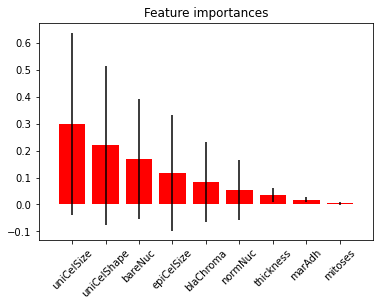

In [318]:
clf = RandomForestClassifier(n_estimators=30)
clf.fit(X_train, y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(min(20,X_train.shape[1])):    
    print("%d. %s (%f)" % (f+1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The result is the same as the second literature. Thus, in summary, de-correlation with PCA also impacts feature importance, because if we "rotate" the data in order to assign into the direction of most variation, the properties of data also change. For some models such as SVM which is sensitive to multi-collinearity, de-correlation makes sense. Whereas for other models not sensitive to multi-collinearity, de-correlation with PCA would lead to incorrect results.

## 7. Discussion:  best feature combination to distinguish benign vs. malignant class

Although SVM model does not provide a good metrics to evaluate the benign v.s malignant class. We can achieve this goal by moving to statistical approaches irrelavant of ML models.

#### a. Imputation

In [28]:
# Reloading dataset
colname = ['code','thickness','uniCelSize','uniCelShape','marAdh','epiCelSize','bareNuc','blaChroma','normNuc','mitoses','class']
dataset = pd.read_csv("breast-cancer-wisconsin.data", names=colname)

# Imputating 'bareNuc' column with median
dataset['bareNuc'] = dataset['bareNuc'].replace('?',0).astype(np.int64)
im = SimpleImputer(missing_values = 0, strategy = 'median')
im_bareNuc = im.fit_transform(dataset[['bareNuc']])
dataset[['bareNuc']] = im_bareNuc

In [312]:
dataset[dataset['bareNuc']=='?']

,code,thickness,uniCelSize,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class


#### b. Split dataset

In [29]:
# Create features and labels 
X = dataset.drop(['code','class'], axis=1)
y = dataset['class']

# Create training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [30]:
y_train.value_counts()

2    340
4    184
Name: class, dtype: int64

In [31]:
y_test.value_counts()

2    118
4     57
Name: class, dtype: int64

#### c. Rebalance

In [32]:
# Data up-sampling
df = pd.concat([X_train, y_train],axis=1)

df_majority = df[df['class']==2] 
df_minority = df[df['class']==4]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=340,
                                 random_state=1)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# re-preparing the training sets
X_train = df_upsampled.drop(['class'], axis=1)
y_train = df_upsampled[['class']]

y_train.value_counts()

class
2        340
4        340
dtype: int64

#### d. Scaling

In [33]:
# Implement scaling using standardiation
standardScaler = StandardScaler()
X_train_scaled = standardScaler.fit_transform(X_train)
X_test_scaled = standardScaler.transform(X_test)

#### e. Statistical analysis

In [34]:
import numpy as np
from sklearn.feature_selection import f_classif
f, p = f_classif(X_train,y_train) # F-test, for the training set and test set before decorrelation
f = list(f)
best_five = sorted(f, reverse=True)[:5]
best_five_features = [X_train.columns[f.index(best)] for best in best_five]
print("The best five attributes are:", best_five_features)

The best five attributes are: ['bareNuc', 'uniCelShape', 'uniCelSize', 'blaChroma', 'thickness']


In [35]:
X_train[best_five_features].join(y_train)

,bareNuc,uniCelShape,uniCelSize,blaChroma,thickness,class
1,10.0,4,4,3,5,2
2,2.0,1,1,3,3,2
3,4.0,8,8,3,6,2
4,1.0,1,1,3,4,2
5,10.0,10,10,9,8,4
...,...,...,...,...,...,...
691,5.0,10,10,4,5,4
691,5.0,10,10,4,5,4
691,5.0,10,10,4,5,4
692,1.0,1,1,1,3,2


#### f. Visualization with pair plots

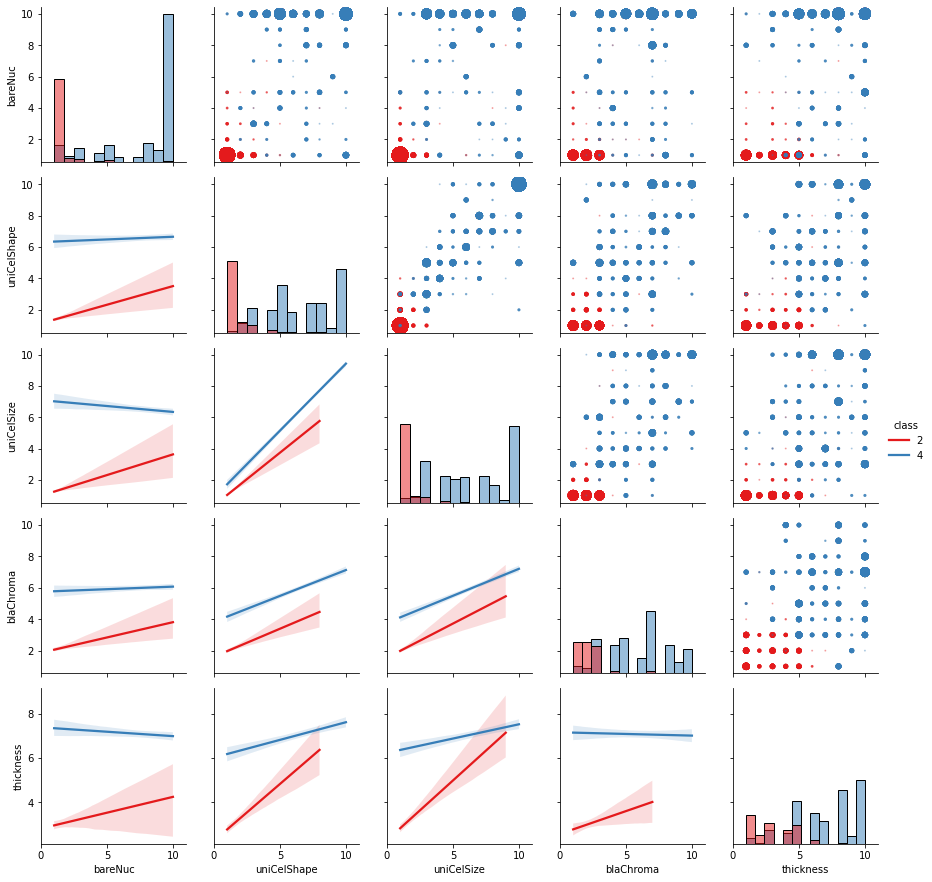

In [39]:
import seaborn as sns
df = X_train[best_five_features].join(y_train)
g = sns.PairGrid(df, hue="class", vars=best_five_features, palette='Set1')
g.map_diag(sns.histplot, alpha=0.5)
g.map_upper(scatterplot)
g.map_lower(sns.regplot, scatter=False)
g.set(xlim=(0, 11))
g.add_legend()
plt.show()

According to bar plots in the diagonal, there is risk if we regard only one feature as the predict factor, because there are overlaids in the distribution of different classes.

However, the combination of two features has a good performance. When we look at the scatter plots, `uniCelShape` and `uniCelS`. They have few overlapping, and benign group samples usually have small uniCels and uniCelShape, whereas melignant ones have both larger values. When looking at their regression line, they are possitive correlated with similar slopes but different intercepts, which means they will be always separated in their confidence intervals.

Also, since we have discussed these two features are highly correlated, the combination of them may be regarded as a single as well as important metrics to predict the cell type.

### *Reference*

**Literature relevant to Wisconsin Breast Cancer (Diagnostic) DataSet**

Ahmad, F. K., & Yusoff, N. (2013, December). Classifying breast cancer types based on fine needle aspiration biopsy data using random forest classifier. In 2013 13th International Conference on Intellient Systems Design and Applications (pp. 121-125). IEEE.

McKinney, Scott Mayer, et al. "International evaluation of an AI system for breast cancer screening." Nature 577.7788 (2020): 89-94.

Sidey-Gibbons, Jenni AM, and Chris J. Sidey-Gibbons. "Machine learning in medicine: a practical introduction." BMC medical research methodology 19.1 (2019): 1-18.

**Previous analysis with regard to feature importance**

Ahmad, F. K., & Yusoff, N. (2013, December). Classifying breast cancer types based on fine needle aspiration biopsy data using random forest classifier. In 2013 13th International Conference on Intellient Systems Design and Applications (pp. 121-125). IEEE.

https://shiring.github.io/machine_learning/2017/01/15/rfe_ga_post

**Remove multicollinearity with PCA**

https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b

**Feature importance estimation with kernel SHAP**

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
https://docs.seldon.io/projects/alibi/en/stable/examples/kernel_shap_wine_intro.html